## Info from papers

## Dendrogram parameters
Σmin = 0.1 g cm−2. We then search for fragmentation in increments of mass surface den- sity ∆Σinc = 0.025 g cm−2 . This is equivalent to the method used by Cheng et al. (2018), if their 1σ noise level of ??? is equivalent to a mass surface density of 0.025 g cm−2 , which is the fiducial conversion factor adopted by these authors. For the third parameter, we require that each core have a projected area equivalent to at least two zones at the finest grid scale, i.e., an area of 2.44 × 10−4 pc2. 

## Qparameter
Qparameter (Cartwright & Whitworth 2004), which is the ratio between the mean length of the edges of the minimumspanning tree (MST) of the cluster,¯m, and the mean separation between stars in the cluster,¯s.

Normalised Correlation Length ¯s (i.e. the mean separation between stars, divided by the overall radius of the
cluster)

Normalised Mean Edge Length ¯m (i.e. the mean length of the branches of the tree, divided by (NtotalA)^1/2/(Ntotal−1), where A is the area of the cluster and Ntotal is the number of stars)

A value Q<0.785 means the cluster is relatively substructured with a lower value corresponding to more clumpiness. In contrast,Q>0.785 means the cluster has an overall radial structure/concentration, with a higher Q value indicating that it is more concentrated in the center


## Imports

In [3]:
#Reading data and plotting
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Dendrogram
from astrodendro import Dendrogram
from astrodendro.analysis import PPStatistic
#MST
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
#Histograms
import collections

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100

## Plotting simulations

yt : [INFO     ] 2021-06-17 00:20:19,953 Parameters: current_time              = 0.047999984165473 code_time
yt : [INFO     ] 2021-06-17 00:20:19,954 Parameters: domain_dimensions         = [2048 2048    1]
yt : [INFO     ] 2021-06-17 00:20:19,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-06-17 00:20:19,956 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-06-17 00:20:19,957 Parameters: cosmological_simulation   = 0.0


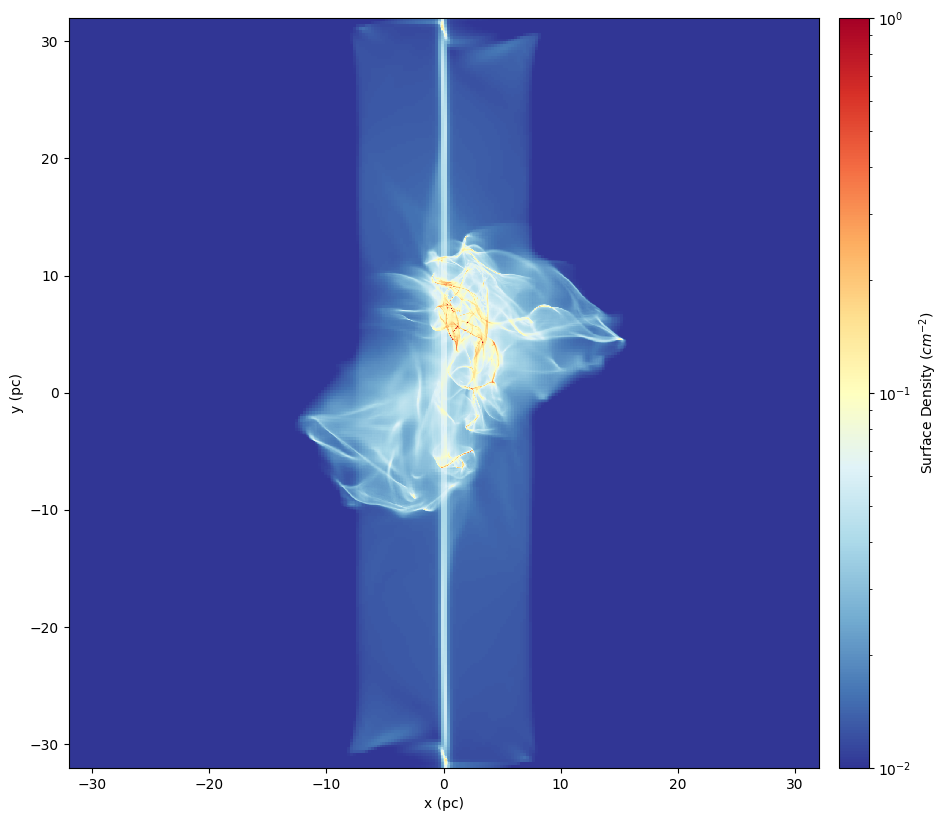

In [6]:
fname = "../frb2048/v10_B10_th60_b05_0030_proj_frb.h5"
ds = yt.load(fname)
ulength = ds.length_unit
normal = [0.2679491, 0, 1.0] # vector normal to cutting plane
north = [0, 1, 0]
width = 0.5
center = [0.5, 0.5, 0.5]
resol = 2048
#dens = yt.off_axis_projection(ds, center, normal, width, resol, "density", north_vector=north).to_ndarray()
data=ds.all_data()["density"]
num=int(np.sqrt(np.shape(data)[0]))

# get density field and convert back to 2-d array
dens = data.reshape(num,-1)

dendro = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=2)
dp = dendro.plotter()

fig, ax = plt.subplots()
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)

l = - 0.5 * width * ulength.in_units("pc")
r = + 0.5 * width * ulength.in_units("pc")
b = - 0.5 * width * ulength.in_units("pc")
t = + 0.5 * width * ulength.in_units("pc")

im = ax.imshow(dens,
    norm=LogNorm(vmin=1e-2, vmax=1.0), 
    aspect="equal",
    origin="lower",
    extent=(l,r,b,t),
    cmap="RdYlBu_r"
)

ax.set_xlabel("x (pc)")
ax.set_ylabel("y (pc)")

cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) #this place the axis
cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
cbar.set_label(r"Surface Density ($cm^{-2}$)")

## MST on top of the simulation

### Offaxis

In [ ]:
B="10"
fname = "./B{}/offaxis/v10_B10_th60_b05_0024.npy".format(B)
ending=".npy"
data=np.load(fname)
print(np.shape(data))

ulength = ds.length_unit
normal = [0.2679491, 0, 1.0] # vector normal to cutting plane
north = [0, 1, 0]
width = 0.5
center = [0.5, 0.5, 0.5]
resol = 4096

dens=data.T
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)

l = - 0.5 * width * ulength.in_units("pc")
r = + 0.5 * width * ulength.in_units("pc")
b = - 0.5 * width * ulength.in_units("pc")
t = + 0.5 * width * ulength.in_units("pc")

im = ax.imshow(dens,
    norm=LogNorm(vmin=1e-2, vmax=1.0), 
    aspect="equal",
    origin="lower",
    extent=(l,r,b,t),
    cmap="RdYlBu_r"
)
ax.set_xlabel("x (pc)")
ax.set_ylabel("y (pc)")

min_pix_=2.44e-4*(resol**2)/(r*2)**2

dendro = Dendrogram.compute(dens, min_value=0.1, min_delta=0.025, min_npix=min_pix_,verbose=False)

num_cores=len(dendro.leaves)
print("Number of cores: ",num_cores) #Number of "cores"-leaves 
positions=[]

#Get the center position of each core
pixoffset = 0.25 * width * ulength.in_units("pc") / resol
ll = - 0.5 * width * ulength.in_units("pc") - pixoffset
rr = + 0.5 * width * ulength.in_units("pc") - pixoffset
bb = - 0.5 * width * ulength.in_units("pc") - pixoffset
tt = + 0.5 * width * ulength.in_units("pc") - pixoffset

pix2leng = width * ulength.in_units("pc") / resol

for leaf in dendro.leaves:

    stat = PPStatistic(leaf)

    xcoord = (stat.x_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
    ycoord = (stat.y_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
    positions.append([xcoord,ycoord])

    #Scatter the center position
    ax.scatter(xcoord,ycoord,color="blue",marker="*", s=0.2)


#Create matrix of distances between cores for the MST
distances=np.zeros((len(positions),len(positions)))

for i,p1 in enumerate(positions):
    for j,p2 in enumerate(positions):
        if(i!=j):
            distances[i][j]=np.sqrt(np.abs(p1[0]-p2[0])**2+np.abs(p1[1]-p2[1])**2)


#Get MST
Tcsr = minimum_spanning_tree(distances)
mst=Tcsr.toarray()

#Get pairs of cores that are connected
pairs=[]
indx=np.where(mst!=0)
for i in range(len(indx[0])):
    pairs.append([np.array(positions[indx[0][i]]),np.array(positions[indx[1][i]])])

#Plot connection between cores
for pair in pairs:
    pair=np.array(pair)
    plt.plot(pair[:,0],pair[:,1],c="k",alpha=0.3)

# colorbar
cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) 
cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
cbar.set_label(r"Surface Density ($cm^{-2}$)")

#Qparameter

#Number of cores
N=len(pairs)+1

#Normalised Correlation Length ¯s
d_cluster=distances.reshape(1,-1)

d_cluster=d_cluster[np.where(d_cluster!=0)]

s=np.mean(d_cluster)

#Normalised Mean Edge Length ¯m
d_mst=np.zeros(N)            

for i,pair in enumerate(pairs):
    d_mst[i]=np.sqrt(np.abs(pair[0][0]-pair[1][0])**2+np.abs(pair[0][1]-pair[1][1])**2)

d_mst=d_mst[np.where(d_mst!=0)]
m=np.mean(d_mst)

#Normalize
m1=m/(((N*np.pi)**0.5)/(N-1))

#Calculate Q

Q1=m1/s
print("Q_normalised:",Q1)

#save figure
figname = fname.replace(ending, ".png")
ax.set_title("B: {}, Q: {:.2f}, Number of cores: {}".format(B,Q1,num_cores))
plt.savefig(figname)

### Normal

yt : [INFO     ] 2021-06-17 00:32:55,206 Parameters: current_time              = 0.059199984121702 code_time
yt : [INFO     ] 2021-06-17 00:32:55,207 Parameters: domain_dimensions         = [8192 8192    1]
yt : [INFO     ] 2021-06-17 00:32:55,208 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-06-17 00:32:55,209 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-06-17 00:32:55,210 Parameters: cosmological_simulation   = 0.0
3.95e+20 cm
Number of cores:  1194
Number of efective cores:  75
Q_normalised: 0.31587028118458216


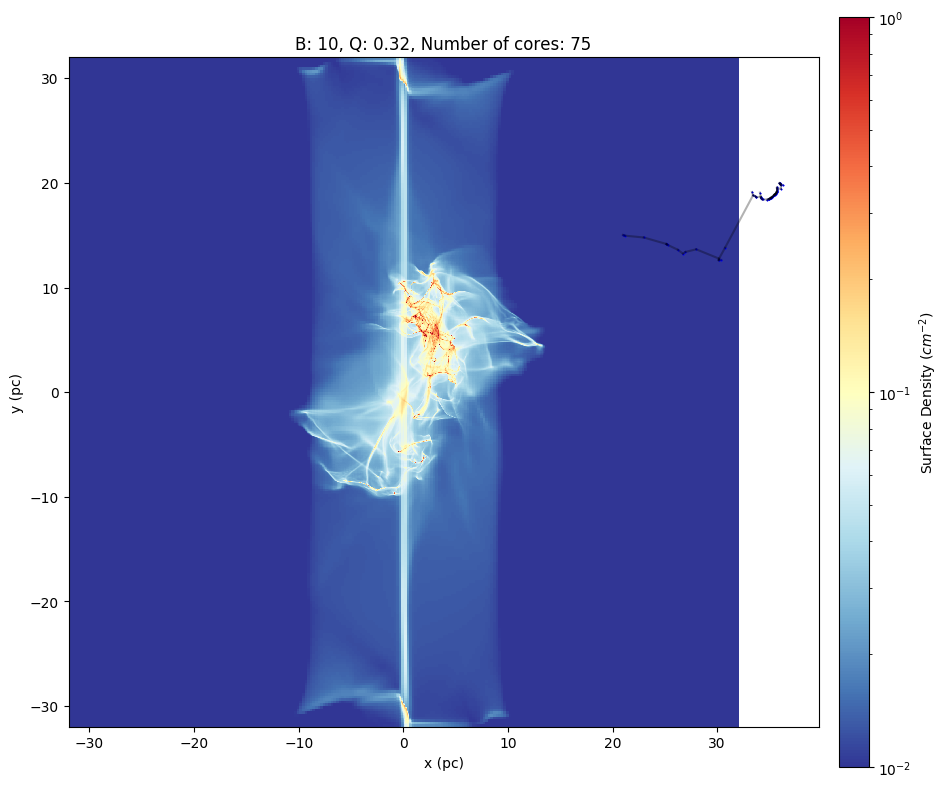

In [10]:
if __name__ == "__main__":
    B="10"
    fname = "../B{}/frb8192/v10_B10_th60_b05_0037_proj_frb.h5".format(B)
    ending=".h5"
    ds = yt.load(fname)
    
    ulength = ds.length_unit
    print(ulength)
    normal = [0.2679491, 0, 1.0] # vector normal to cutting plane
    north = [0, 1, 0]
    width = 0.5
    center = [0.5, 0.5, 0.5]
    resol = 4096

    # list all field
    
    data=ds.all_data()["density"]
    num=int(np.sqrt(np.shape(data)[0]))

    # get density field and convert back to 2-d array
    dens = data.reshape(num,-1)
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)

    l = - 0.5 * width * ulength.in_units("pc")
    r = + 0.5 * width * ulength.in_units("pc")
    b = - 0.5 * width * ulength.in_units("pc")
    t = + 0.5 * width * ulength.in_units("pc")

    im = ax.imshow(dens,
        norm=LogNorm(vmin=1e-2, vmax=1.0), 
        aspect="equal",
        origin="lower",
        extent=(l,r,b,t),
        cmap="RdYlBu_r"
    )
    ax.set_xlabel("x (pc)")
    ax.set_ylabel("y (pc)")

    #Calculate dendogram
    min_pix_=2.44e-4*(resol**2)/(r*2)**2 #area from pixels to physical coordinates
    dendro = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=min_pix_,verbose=False)

    num_cores=len(dendro.leaves)
    print("Number of cores: ",num_cores) #Number of "cores"-leaves
    positions=[]

    #Get the center position of each core
    pixoffset = 0.25 * width * ulength.in_units("pc") / resol
    ll = - 0.5 * width * ulength.in_units("pc") - pixoffset
    rr = + 0.5 * width * ulength.in_units("pc") - pixoffset
    bb = - 0.5 * width * ulength.in_units("pc") - pixoffset
    tt = + 0.5 * width * ulength.in_units("pc") - pixoffset

    pix2leng = width * ulength.in_units("pc") / resol

    for leaf in dendro.leaves:

        stat = PPStatistic(leaf)

        xcoord = (stat.x_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
        ycoord = (stat.y_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
        if(ycoord<20 and ycoord>-20): #Here we remove "cores" too far from the center
            positions.append([xcoord,ycoord])

            #Scatter the center position
            ax.scatter(xcoord,ycoord,color="blue",marker="*", s=0.2)

    print("Number of efective cores: ",len(positions)) #Number of "cores"-leaves without "cores" too far from the center
    
    #Create matrix of distances between cores for the MST
    distances=np.zeros((len(positions),len(positions)))

    for i,p1 in enumerate(positions):
        for j,p2 in enumerate(positions):
            if(i!=j):
                distances[i][j]=np.sqrt(np.abs(p1[0]-p2[0])**2+np.abs(p1[1]-p2[1])**2)


    #Get MST
    Tcsr = minimum_spanning_tree(distances)
    mst=Tcsr.toarray()

    #Get pairs of cores that are connected
    pairs=[]
    indx=np.where(mst!=0)
    for i in range(len(indx[0])):
        pairs.append([np.array(positions[indx[0][i]]),np.array(positions[indx[1][i]])])

    #Plot connection between cores
    for pair in pairs:
        pair=np.array(pair)
        plt.plot(pair[:,0],pair[:,1],c="k",alpha=0.3)

    # colorbar
    cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) 
    cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
    cbar.set_label(r"Surface Density ($cm^{-2}$)")
    
    #Qparameter

    #Number of cores
    N=len(pairs)+1

    #Normalised Correlation Length ¯s
    d_cluster=distances.reshape(1,-1)

    d_cluster=d_cluster[np.where(d_cluster!=0)]

    s=np.mean(d_cluster)

    #Normalised Mean Edge Length ¯m
    d_mst=np.zeros(N)            

    for i,pair in enumerate(pairs):
        d_mst[i]=np.sqrt(np.abs(pair[0][0]-pair[1][0])**2+np.abs(pair[0][1]-pair[1][1])**2)

    d_mst=d_mst[np.where(d_mst!=0)]
    m=np.mean(d_mst)

    #Normalize
    m1=m/(((N*np.pi)**0.5)/(N-1))

    #Calculate Q

    Q1=m1/s
    print("Q_normalised:",Q1)

    #save figure
    figname = fname.replace(ending, ".png")
    ax.set_title("B: {}, Q: {:.2f}, Number of cores: {}".format(B,Q1,len(positions)))
    plt.savefig(figname)

### Qparameter

In [ ]:
#Qparameter

#Number of cores
N=len(pairs)+1

#Normalised Correlation Length ¯s
d_cluster=distances.reshape(1,-1)

d_cluster=d_cluster[np.where(d_cluster!=0)]

s=np.mean(d_cluster)

#Normalised Mean Edge Length ¯m
d_mst=np.zeros(N)            
            
for i,pair in enumerate(pairs):
    d_mst[i]=np.sqrt(np.abs(pair[0][0]-pair[1][0])**2+np.abs(pair[0][1]-pair[1][1])**2)
                    
d_mst=d_mst[np.where(d_mst!=0)]
m=np.mean(d_mst)

#Normalize
m1=m/(((N*np.pi)**0.5)/(N-1))

#Calculate Q
Q=m/s

Q1=m1/s
print("m:",m,", m_normalised:",m1,", s:",s,", Q:",Q,", Q_normalised:",Q1)

## Histograms

### Edges by core

In [ ]:
c_edges=collections.Counter()

counter={}

for pair in pairs:
    for i in range(2):
        try:
            counter[str(pair[i][0])+","+str(pair[i][1])]+=1
        except:
            counter[str(pair[i][0])+","+str(pair[i][1])]=1
            
num_edges=counter.values()
c_edges.update(num_edges)

coresw2edges=np.array([np.array(k.split(",")).astype(np.float) for k,v in counter.items() if v == 2])

plt.bar(c_edges.keys(),c_edges.values(),color='#607c8e')
plt.xlabel("Number of edges by core")
plt.ylabel("Number of cores")
#plt.hist(num_edges)
print(c_edges)

#save figure
figname = fname.replace(ending, "_hist_ebc.png")
plt.savefig(figname)

### Distances of MST

In [ ]:
c_distances=collections.Counter(d_mst)
print(len(list(c_distances.keys())))

plt.hist(d_mst,rwidth=0.9,color='#607c8e',bins=50)
plt.xlabel("Length (pc)")
plt.ylabel("Number of edges")

#save figure
figname = fname.replace(ending, "_hist_dMST.png")
plt.savefig(figname)

In [ ]:
#Duplicated
dist=np.array([[k,v] for k,v in c_distances.items() if v >= 2])
print(dist)
plt.bar(dist[:,0],dist[:,1],width=0.01,color='#607c8e')

### Angles from cores with 2 edges

In [ ]:
pairsw2edges=[]
for corew2edges in coresw2edges:
    pair_=[]
    for pair in pairs:
        if(corew2edges==pair[0]).all() or (corew2edges==pair[1]).all():
            pair_.append(pair)
            
    pairsw2edges.append(np.array(pair_))
    if(len(pair_)>2):
        print(corew2edges)
        print(pair_)
print(len(pairsw2edges)) 
print(pairsw2edges[0]) 

print(len(coresw2edges))

#pairsw2edges=[[pairs[np.where(pairs==corew2edges)[0][0]],pairs[np.where(pairs==corew2edges)[0][2]]] for corew2edges in coresw2edges]

print(len(pairsw2edges))

#print(pairsw2edges[0])

colors = plt.cm.jet(np.linspace(0,1,len(pairsw2edges)))

for pairs2 in pairsw2edges:
    cc=np.random.randint(0,len(pairsw2edges))
    for pair in pairs2:
        plt.plot(pair[:,0],pair[:,1],'o-',c=colors[cc],markersize=2)
plt.axis("equal")
plt.xlabel("x (pc)",fontsize=20)
plt.ylabel("y (pc)",fontsize=20)

"""#save figure
figname = fname.replace(ending, "_MSTw2edges.png")
plt.savefig(figname)"""

In [ ]:
def angle(d_b,d_c,d_a):
    return np.rad2deg(np.arccos(((d_b**2)+(d_c**2)-(d_a**2))/(2*d_b*d_c)))

def length(x1,y1,x2,y2):
    return np.sqrt(((x1-x2)**2)+((y1-y2)**2))

angles=[]
for pairw2edges in pairsw2edges:
    d_pp=[]
    p_pp={}
    for ppi in pairw2edges:
        p_pp[str(ppi[0])+","+str(ppi[1])]=0
        p_pp[str(ppi[1])+","+str(ppi[0])]=0
        d_pp.append(length(*ppi[0],*ppi[1]))
        
    for ppi in pairw2edges[0]:
        for ppi2 in pairw2edges[1]:
            l=length(*ppi,*ppi2)
            if l!=0:
                if p_pp.get(str(ppi)+","+str(ppi2))==None:
                    p_pp[str(ppi)+","+str(ppi2)]=0
                    p_pp[str(ppi2)+","+str(ppi)]=0
                    d_pp.append(l)

    A=angle(*d_pp)
    angles.append(A)
    
    """try:
        A=angle(*d_pp)
        angles.append(A)
        B=angle(d_pp[0],d_pp[2],d_pp[1])
        C=angle(d_pp[1],d_pp[2],d_pp[0])
    except:
        cc=np.random.randint(0,len(pairsw2edges))
        print(pairw2edges)
        #print(length(*pairw2edges[0][1],*pairw2edges[0][0]))
        print(d_pp)
        for pair in pairw2edges:
        plt.plot(np.array(pair)[:,0],np.array(pair)[:,1],'o-',c=colors[cc],markersize=1.5)
        plt.axis("equal")
        """
    #print("A",A)
    """print("Otro",B)
    print("Otro",C)
    print("sum",A+B+C)"""

print(len(angles))
plt.hist(angles,bins=20,color='#607c8e')
plt.xlabel("Angle(°)")
plt.ylabel("Number of cores")#That join the two edges

#save figure
figname = fname.replace(ending, "_hist_anglesMSTw2edges.png")
plt.savefig(figname)

### Angles from cores with 3 edges